## Figure 6. Application to biofeedback

### Imports

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import numpy.linalg as la
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
from lib.mu_w_2_20 import mu_mean

from lib.lif import LIF, ParamsLIF

from statsmodels.nonparametric.smoothers_lowess import lowess

Populating the interactive namespace from numpy and matplotlib


In [3]:
def convolve_online(s, h, kernel, t_offset):
    #print np.nonzero(h)[0]
    for idx in np.nonzero(h)[0]:
        st = t_offset + idx
        en = min(s.shape[0], st + kernel.shape[0])
        ln = en-st
        #print st,en,ln,idx,t_offset
        s[st:en] += kernel[0:ln]

In [4]:
#Keep stepsize constant
decaystepsize = False
linearcorrection = False

### First run without correlation, unperturbed cost function

In [5]:
q = 3                      #Dimension of learnt vector
dt = 0.001                 #Simulation timestep
DeltaT = 50                #Number of timebins over which learning rule is applied
tsim = 500                 #Total simulation time
t = DeltaT*dt              #Learning block sim time
T = int((tsim/dt)/DeltaT)  #Number of learning blocks
Nsims = 1                  #Number of repeated simulations
x_input = 0                #Input
n = 10                     #Number of neurons
sigma = 10                 #Their noise level
sigma_perturb = 20         #Perturbation noise level
mu = 1                     #Spiking threshold
tau = 1                    #Neuron timescale
eta = 1e-1                 #Cost gradient learning rate (RDD)
epsilon = 1e4              #Weight learning rate (RDD)
epsilon_np = 1e-1          #Weight learning rate (NP)
epsilon_np_baseline = 1e-1 #Weight learning rate with baseline (NP)
tau_s = 0.20               #Output filter timescale

t_no_w = 0                 #Time to not change w, to let beta adjust

#c = 0.5                    #Correlation coefficient
c = 0.01

p = 0.2                     #Learning window
#p = 1                     #Learning window

wmin = 2
wmax = 20
Nmu = 19

ncost = n                  #Number of cost function components
gamma = 1                  #Weight given to perturbed cost function component

In [6]:
#Create simulation object
params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c, n = n)

#Random weights
W_rdd = 10*rand.rand(n) 
#W_rdd = 10*np.ones(n)
t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#Create original and perturbed cost function
#U = 10*np.abs(rand.rand(ncost, n))
#starget = 0.02*np.ones(n)
#target = np.dot(U, starget)

U = np.eye(n)
target = .02*np.ones(n)
U_p = np.zeros((1, n))
#Target neuron is first neuron
U_p[0,0] = 1
#target_p = np.ones((1,1))*0.1
#target_p = np.ones((1,1))*0
target_p = target.copy()
target_p[0] = 0

#C_orig = lambda s: la.norm(np.dot(U, s) - np.matlib.repmat(target, 1, s.shape[1]), axis = 0)
#C_perturb = lambda s: C_orig(s) + la.norm(np.dot(U_p, s) - np.matlib.repmat(target_p, 1, s.shape[1]), axis = 0)*gamma

C_orig = lambda s: la.norm(np.dot(U, s) - target)
#C_perturb = lambda s: C_orig(s) + la.norm(np.dot(U_p, s) - target_p)*gamma
C_perturb = lambda s: la.norm(np.dot(U, s) - target_p)

costs_orig = np.zeros((Nsims, T))

W_rdd_trace = np.zeros((Nsims, T, n))
V_trace = np.zeros((Nsims, T, n))

In [7]:
starget = np.dot(la.inv(U), target)
starget

array([ 0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02])

In [8]:
#Simulate with RDD learning rule for original cost function, same simulation can be used for all c values. 
#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go

s_raw = np.zeros((n, T*DeltaT))
    
for idx in range(Nsims):
    #Create the filtered output vectors now, fill them as we go
    #s_raw = np.zeros((n,int(T/dt)))
    s_raw = np.zeros((n, T*DeltaT))
    
    lif_rdd = LIF(params_lif, t = DeltaT*dt, t_total = tsim)
    lif_rdd.W = W_rdd.copy()
    lif_rdd.x = x_input

    count = np.zeros(n)
    sys.stdout.write('.')
    sys.stdout.flush()

    lif_rdd.count = 0
    bt = [False]*n

    V = np.zeros((n, q))
    #Then just repeat the learning rule as before
    dV = np.zeros(V.shape)

    for j in range(T):
        #Simulate LIF for RDD
        #print("t = %d"%j)
        (v_raw, h_raw, _, _, u_raw) = lif_rdd.simulate(DeltaT)

        t_offset = j*DeltaT
        for k in range(n):
            convolve_online(s_raw[k,:], h_raw[k,:], exp_filter, t_offset)
        nB = h_raw.shape[1]/DeltaT 
        um = u_raw.reshape((n, nB, DeltaT))
        u = np.max(um, 2)

        cost = C_orig(s_raw[:,t_offset+DeltaT-1])
        #print cost         
        for k in range(n):
            if (u[k,0] > mu - p) & (u[k,0] < mu):
                if bt[k] == False:
                    if linearcorrection == True:
                        ahat = np.array([1, 0, -(u[k,0]-mu)])
                    else:
                        ahat = np.array([1, 0, 0])
                    dV[k,:] += (np.dot(V[k,:], ahat)+cost)*ahat                    
                    bt[k] = True
            elif (u[k,0] < mu + p) & (u[k,0] >= mu):
                #Only do the update when firing...
                if bt[k] == True:
                    if linearcorrection == True:
                        ahat = np.array([1, (u[k,0]-mu), 0])
                    else:
                        ahat = np.array([1, 0, 0])
                    dV[k,:] += (np.dot(V[k,:], ahat)-cost)*ahat                                        
                    count[k] += 1
                    if decaystepsize == True:
                        V[k,:] = V[k,:] - eta*dV[k,:]/(count[k]+1)
                    else:
                        V[k,:] = V[k,:] - eta*dV[k,:]
                    dV[k,:] = np.zeros((1,q))
                    bt[k] = False
                
        #At end of episode, update weights according to V for RDD
        if j*DeltaT*dt > t_no_w:
            lif_rdd.W -= epsilon*np.multiply(V[:,0], mu_mean(lif_rdd.W, wmin, wmax, Nmu))#/(j+100)
            lif_rdd.W = np.maximum(np.minimum(lif_rdd.W, wmax), wmin)
        W_rdd_trace[idx,j,:] = lif_rdd.W
        V_trace[idx,j,:] = V[:,0]
        costs_orig[idx,j] = cost
        
W_rdd_orig = W_rdd.copy()


.

array([ 17.83747429,  17.1470938 ,  20.        ,  18.29045823,
        16.55337303,  17.10117986,  14.84228984,  19.94000602,
        20.        ,  18.90187104])

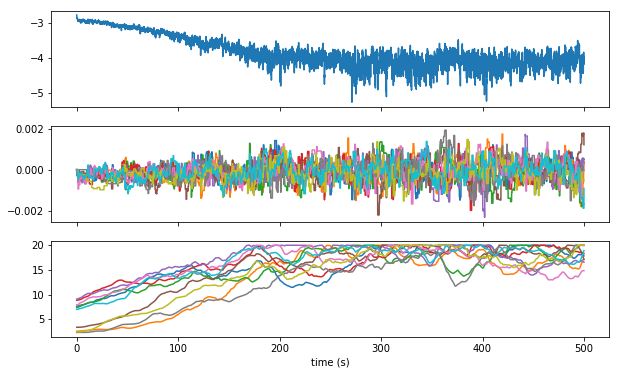

In [8]:
#Check that it converged. Plot cost trace
fig, axes = plt.subplots(3, 1, sharex = True)
axes[0].plot(DeltaT*dt*np.arange(costs_orig.shape[1]), np.log(costs_orig.T))
axes[1].plot(DeltaT*dt*np.arange(costs_orig.shape[1]), V_trace[0,:,:])
axes[2].plot(DeltaT*dt*np.arange(costs_orig.shape[1]), W_rdd_trace[0,0:,:]);
axes[2].set_xlabel('time (s)')
lif_rdd.W

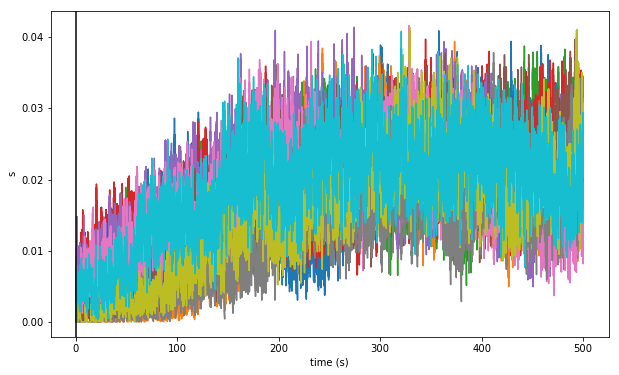

In [9]:
#Simulate nsim times with perturbed cost function for each c value with RDD learning rule

#Check out what s_raw is doing...
#plt.plot(s_raw[:,0:40000].T);
plt.plot(dt*np.arange(s_raw.shape[1]), s_raw[:,:].T);
a=np.sum(s_raw[1,:]>0)
a/float(s_raw.shape[1])
plt.axvline(x = t_no_w, color = (0,0,0))
plt.xlabel('time (s)')
plt.ylabel('s')

### Then run with a perturbed cost function

Run for different c and p values

In [25]:
U_p = np.zeros((1, n))
#Target neuron is first neuron
U_p[0,0] = 1
#target_p = np.ones((1,1))*0.1
#target_p = np.ones((1,1))*0

targetpval = 0
target_p = target.copy()
target_p[0] = targetpval

gamma = 1

C_perturb_DC = lambda s: C_orig(s) + la.norm(np.dot(U_p, s) - targetpval)*gamma
C_perturb_BC = lambda s: la.norm(np.dot(U_p, s) - targetpval)
C_perturb = lambda s: la.norm(np.dot(U, s) - target_p)

W_rdd_orig = W_rdd.copy()

In [26]:
np.dot(U_p, np.ones((1,n)).T) - 1
target_p

array([ 0.  ,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02])

In [42]:
cvals = [0.1, 0.3, 0.5, 0.7, 0.9]
pvals = [0.2, 1]
epsilon_vals = [1e4, 5e4]

Nsims = 40

nCvals = len(cvals)
nPvals = len(pvals)

W_rdd_trace_pert = np.zeros((nCvals, nPvals, Nsims, T, n))
V_trace_pert = np.zeros((nCvals, nPvals, Nsims, T, n))
costs_pert = np.zeros((nCvals, nPvals, Nsims, T))

In [43]:
#Simulate with RDD learning rule for original cost function, same simulation can be used for all c values. 
#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go

for cidx, c in enumerate(cvals):
    print 'Running for c = %f'%c
    for pidx, p in enumerate(pvals):
        print 'Running for p = %f'%p
        epsilon = epsilon_vals[pidx] 

        #Update lif object's c value
        params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c, n = n)

        for idx in range(Nsims):
            #Create the filtered output vectors now, fill them as we go
            #s_raw = np.zeros((n,int(T/dt)))
            s_raw = np.zeros((n, T*DeltaT))

            lif_rdd = LIF(params_lif, t = DeltaT*dt, t_total = tsim)
            lif_rdd.W = W_rdd_orig.copy()
            lif_rdd.x = x_input

            count = np.zeros(n)
            sys.stdout.write('.')
            sys.stdout.flush()

            lif_rdd.count = 0
            bt = [False]*n

            V = np.zeros((n, q))
            #Then just repeat the learning rule as before
            dV = np.zeros(V.shape)

            for j in range(T):
                #Simulate LIF for RDD
                #print("t = %d"%j)
                (v_raw, h_raw, _, _, u_raw) = lif_rdd.simulate(DeltaT)

                t_offset = j*DeltaT
                for k in range(n):
                    convolve_online(s_raw[k,:], h_raw[k,:], exp_filter, t_offset)
                nB = h_raw.shape[1]/DeltaT 
                um = u_raw.reshape((n, nB, DeltaT))
                u = np.max(um, 2)

                cost = C_perturb(s_raw[:,t_offset+DeltaT-1])
                #cost = C_perturb_DC(s_raw[:,t_offset+DeltaT-1])
                #print cost         
                for k in range(n):
                    if (u[k,0] > mu - p) & (u[k,0] < mu):
                        if bt[k] == False:
                            if linearcorrection == True:
                                ahat = np.array([1, 0, -(u[k,0]-mu)])
                            else:
                                ahat = np.array([1, 0, 0])
                            dV[k,:] += (np.dot(V[k,:], ahat)+cost)*ahat                    
                            bt[k] = True
                    elif (u[k,0] < mu + p) & (u[k,0] >= mu):
                        #Only do the update when firing...
                        if bt[k] == True:
                            if linearcorrection == True:
                                ahat = np.array([1, (u[k,0]-mu), 0])
                            else:
                                ahat = np.array([1, 0, 0])
                            dV[k,:] += (np.dot(V[k,:], ahat)-cost)*ahat                                        
                            count[k] += 1
                            if decaystepsize == True:
                                V[k,:] = V[k,:] - eta*dV[k,:]/(count[k]+1)
                            else:
                                V[k,:] = V[k,:] - eta*dV[k,:]
                            dV[k,:] = np.zeros((1,q))
                            bt[k] = False
                
                #At end of episode, update weights according to V for RDD
                if j*DeltaT*dt > t_no_w:
                    lif_rdd.W -= epsilon*np.multiply(V[:,0], mu_mean(lif_rdd.W, wmin, wmax, Nmu))#/(j+100)
                    lif_rdd.W = np.maximum(np.minimum(lif_rdd.W, wmax), wmin)
                W_rdd_trace_pert[cidx, pidx, idx,j,:] = lif_rdd.W
                V_trace_pert[cidx, pidx, idx,j,:] = V[:,0]
                costs_pert[cidx, pidx, idx,j] = cost

Running for c = 0.100000
Running for p = 0.200000
........................................Running for p = 1.000000
........................................Running for c = 0.300000
Running for p = 0.200000
........................................Running for p = 1.000000
........................................Running for c = 0.500000
Running for p = 0.200000
........................................Running for p = 1.000000
........................................Running for c = 0.700000
Running for p = 0.200000
........................................Running for p = 1.000000
........................................Running for c = 0.900000
Running for p = 0.200000
........................................Running for p = 1.000000
........................................

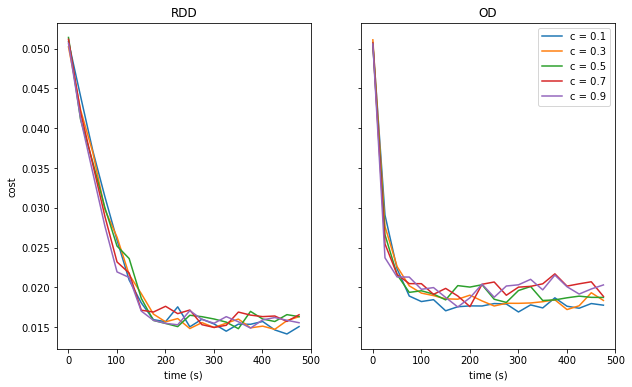

In [44]:
#Make some plots of progress
fig, axes = plt.subplots(1,2, sharey = True)

#RDD
tt=10
step = 500
ii = np.arange(tt,costs_pert.shape[-1],step).T
axes[0].plot(DeltaT*dt*ii, np.mean(costs_pert[:,0,:,ii],2))
axes[0].set_xlabel('time (s)')
axes[0].set_title('RDD')
axes[0].set_ylabel('cost')
#OD
axes[1].set_title('OD')
axes[1].plot(DeltaT*dt*ii, np.mean(costs_pert[:,1,:,ii],2))
axes[1].set_xlabel('time (s)')
axes[1].legend(['c = 0.1', 'c = 0.3', 'c = 0.5', 'c = 0.7','c = 0.9'])

In [35]:
ii.shape

(20,)

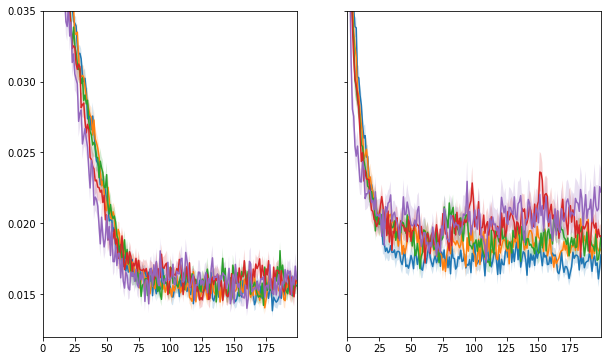

In [45]:
fig, axes = plt.subplots(1,2, sharey = True)
step = 50
ii = np.arange(0,costs_pert.shape[-1],step)
times = DeltaT*dt*ii

for idx in range(len(cvals)):
    sns.tsplot(data = costs_pert[idx,0,:,ii].T, ax = axes[0], color='C%d'%idx)
    sns.tsplot(data = costs_pert[idx,1,:,ii].T, ax = axes[1], color='C%d'%idx)

axes[0].set_ylim([0.012, 0.035])
axes[1].set_ylim([0.012, 0.035])
plt.savefig('./fig_6_rd_vs_od.eps')

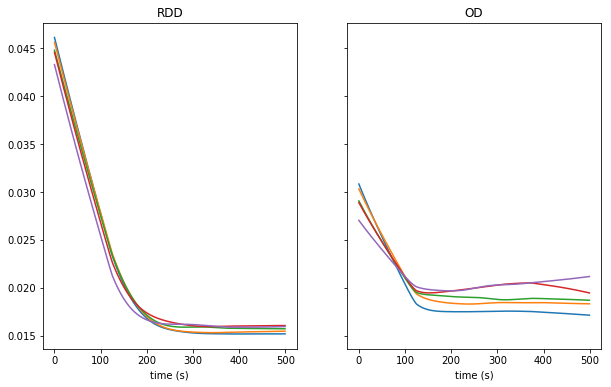

In [46]:
#Make some plots of progress
fig, axes = plt.subplots(1,2, sharey = True)
tt=10
time = DeltaT*dt*np.arange(costs_pert.shape[-1]-tt)

#Smooth with loess
#RDD
for idx in range(len(cvals)):
    pp = np.mean(costs_pert[idx,0,:,tt:], 0)
    filtered = lowess(pp, time, is_sorted=True, frac=0.5, it=0)
    axes[0].plot(filtered[:,0], (filtered[:,1]))
    #axes[0].plot(filtered[:,0], np.log(filtered[:,1]))

axes[0].set_xlabel('time (s)')
axes[0].set_title('RDD')
#axes[0].set_ylim([0, 0.02])

#OD
for idx in range(len(cvals)):
    pp = np.mean(costs_pert[idx,1,:,tt:], 0)
    filtered = lowess(pp, time, is_sorted=True, frac=0.5, it=0)
    axes[1].plot(filtered[:,0], (filtered[:,1]))
    #axes[1].plot(filtered[:,0], np.log(filtered[:,1]))

axes[1].set_xlabel('time (s)')
axes[1].set_title('OD')
#axes[1].set_ylim([0, 0.02])

plt.savefig('./fig_6.eps')

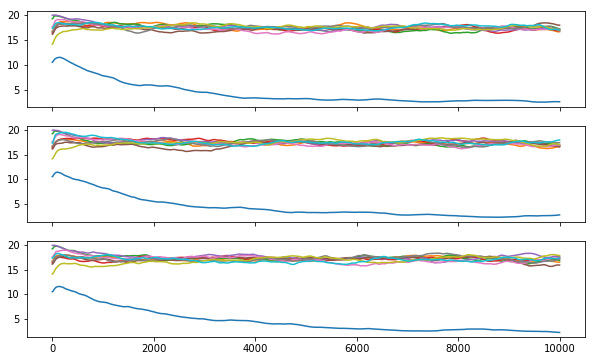

In [897]:
#Check what the weights are doing

#W_rdd_trace_pert[cidx,pidx,Nsim,time,weightidx]
#Example
fig, axes = plt.subplots(3,1, sharex = True)
axes[0].plot(np.mean(W_rdd_trace_pert[0,0,:,:,:], 0));
axes[1].plot(np.mean(W_rdd_trace_pert[1,0,:,:,:], 0));
axes[2].plot(np.mean(W_rdd_trace_pert[2,0,:,:,:], 0));

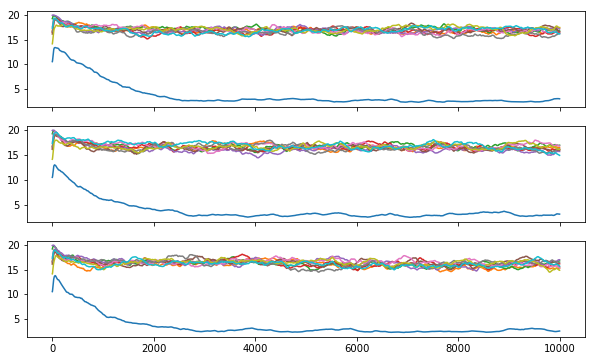

In [898]:
fig, axes = plt.subplots(3,1, sharex = True)
axes[0].plot(np.mean(W_rdd_trace_pert[0,1,:,:,:], 0));
axes[1].plot(np.mean(W_rdd_trace_pert[1,1,:,:,:], 0));
axes[2].plot(np.mean(W_rdd_trace_pert[2,1,:,:,:], 0));

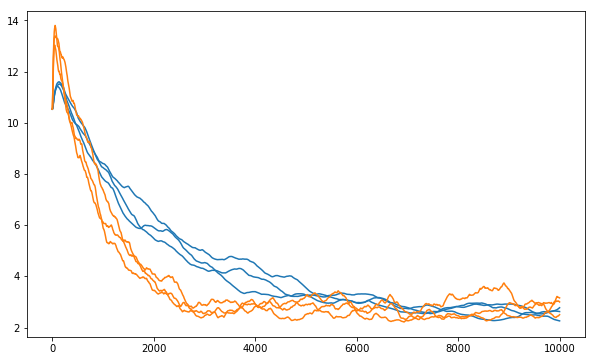

In [899]:
plt.plot(np.mean(W_rdd_trace_pert[0,0,:,:,0], 0), 'C0')
plt.plot(np.mean(W_rdd_trace_pert[1,0,:,:,0], 0), 'C0')
plt.plot(np.mean(W_rdd_trace_pert[2,0,:,:,0], 0), 'C0')

plt.plot(np.mean(W_rdd_trace_pert[0,1,:,:,0], 0), 'C1')
plt.plot(np.mean(W_rdd_trace_pert[1,1,:,:,0], 0), 'C1')
plt.plot(np.mean(W_rdd_trace_pert[2,1,:,:,0], 0), 'C1')

## Brain control task

In [10]:
U_p = np.zeros((1, n))
#Target neuron is first neuron
U_p[0,0] = 1
#target_p = np.ones((1,1))*0.1
#target_p = np.ones((1,1))*0

targetpval = 0
target_p = target.copy()
target_p[0] = targetpval

gamma = 1

W_rdd_orig = W_rdd.copy()

In [11]:
np.dot(U_p, np.ones((1,n)).T) - 1
target_p

array([ 0.  ,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02])

In [12]:
cvals = [0.1, 0.3, 0.5, 0.7, 0.9]
pvals = [0.2, 1]
epsilon_vals = [1e4, 5e4]

Nsims = 40

nCvals = len(cvals)
nPvals = len(pvals)

W_rdd_trace_pert = np.zeros((nCvals, nPvals, Nsims, T, n))
V_trace_pert = np.zeros((nCvals, nPvals, Nsims, T, n))
costs_pert = np.zeros((nCvals, nPvals, Nsims, T))

In [13]:
#Simulate with RDD learning rule for original cost function, same simulation can be used for all c values. 
#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go

for cidx, c in enumerate(cvals):
    print 'Running for c = %f'%c
    for pidx, p in enumerate(pvals):
        print 'Running for p = %f'%p
        epsilon = epsilon_vals[pidx] 

        #Update lif object's c value
        params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c, n = n)

        for idx in range(Nsims):
            #Create the filtered output vectors now, fill them as we go
            #s_raw = np.zeros((n,int(T/dt)))
            s_raw = np.zeros((n, T*DeltaT))

            lif_rdd = LIF(params_lif, t = DeltaT*dt, t_total = tsim)
            lif_rdd.W = W_rdd_orig.copy()
            lif_rdd.x = x_input

            count = np.zeros(n)
            sys.stdout.write('.')
            sys.stdout.flush()

            lif_rdd.count = 0
            bt = [False]*n

            V = np.zeros((n, q))
            #Then just repeat the learning rule as before
            dV = np.zeros(V.shape)

            for j in range(T):
                #Simulate LIF for RDD
                #print("t = %d"%j)
                (v_raw, h_raw, _, _, u_raw) = lif_rdd.simulate(DeltaT)

                t_offset = j*DeltaT
                for k in range(n):
                    convolve_online(s_raw[k,:], h_raw[k,:], exp_filter, t_offset)
                nB = h_raw.shape[1]/DeltaT 
                um = u_raw.reshape((n, nB, DeltaT))
                u = np.max(um, 2)

                cost = C_perturb_BC(s_raw[:,t_offset+DeltaT-1])
                #print cost         
                for k in range(n):
                    if (u[k,0] > mu - p) & (u[k,0] < mu):
                        if bt[k] == False:
                            if linearcorrection == True:
                                ahat = np.array([1, 0, -(u[k,0]-mu)])
                            else:
                                ahat = np.array([1, 0, 0])
                            dV[k,:] += (np.dot(V[k,:], ahat)+cost)*ahat                    
                            bt[k] = True
                    elif (u[k,0] < mu + p) & (u[k,0] >= mu):
                        #Only do the update when firing...
                        if bt[k] == True:
                            if linearcorrection == True:
                                ahat = np.array([1, (u[k,0]-mu), 0])
                            else:
                                ahat = np.array([1, 0, 0])
                            dV[k,:] += (np.dot(V[k,:], ahat)-cost)*ahat                                        
                            count[k] += 1
                            if decaystepsize == True:
                                V[k,:] = V[k,:] - eta*dV[k,:]/(count[k]+1)
                            else:
                                V[k,:] = V[k,:] - eta*dV[k,:]
                            dV[k,:] = np.zeros((1,q))
                            bt[k] = False
                
                #At end of episode, update weights according to V for RDD
                if j*DeltaT*dt > t_no_w:
                    lif_rdd.W -= epsilon*np.multiply(V[:,0], mu_mean(lif_rdd.W, wmin, wmax, Nmu))#/(j+100)
                    lif_rdd.W = np.maximum(np.minimum(lif_rdd.W, wmax), wmin)
                W_rdd_trace_pert[cidx, pidx, idx,j,:] = lif_rdd.W
                V_trace_pert[cidx, pidx, idx,j,:] = V[:,0]
                costs_pert[cidx, pidx, idx,j] = cost

Running for c = 0.100000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.300000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.500000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.700000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.900000
Running for p = 0.200000
....................Running for p = 1.000000
....................

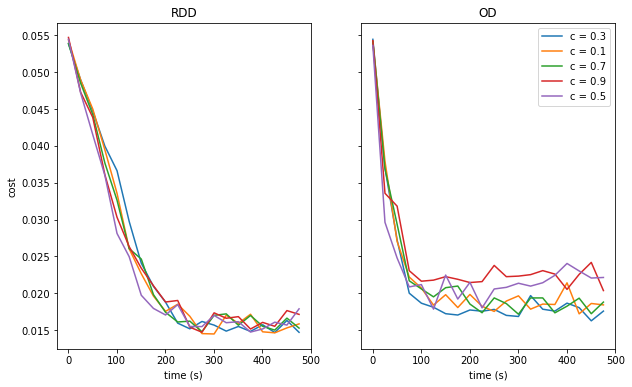

In [16]:
#Make some plots of progress
fig, axes = plt.subplots(1,2, sharey = True)

#RDD
tt=10
step = 500
ii = np.arange(tt,costs_pert.shape[-1],step).T
axes[0].plot(DeltaT*dt*ii, np.mean(costs_pert[:,0,:,ii],2))
axes[0].set_xlabel('time (s)')
axes[0].set_title('RDD')
axes[0].set_ylabel('cost')
#OD
axes[1].set_title('OD')
axes[1].plot(DeltaT*dt*ii, np.mean(costs_pert[:,1,:,ii],2))
axes[1].set_xlabel('time (s)')
axes[1].legend(['c = 0.1', 'c = 0.3', 'c = 0.5', 'c = 0.7','c = 0.9'])

In [984]:
ii.shape

(10000,)

/home/lansdell/.local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0.01, 0.04)

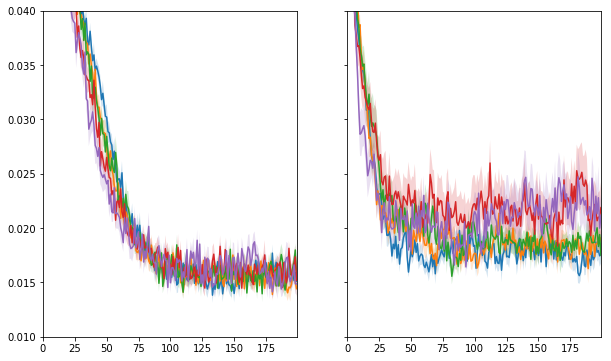

In [17]:
fig, axes = plt.subplots(1,2, sharey = True)
tt=10
step = 50
ii = np.arange(0,costs_pert.shape[-1],step)
times = DeltaT*dt*ii

for idx in range(len(cvals)):
    sns.tsplot(data = costs_pert[idx,0,:,ii].T, ax = axes[0], color='C%d'%idx)
    sns.tsplot(data = costs_pert[idx,1,:,ii].T, ax = axes[1], color='C%d'%idx)

axes[0].set_ylim([0.01, 0.04])
axes[1].set_ylim([0.01, 0.04])

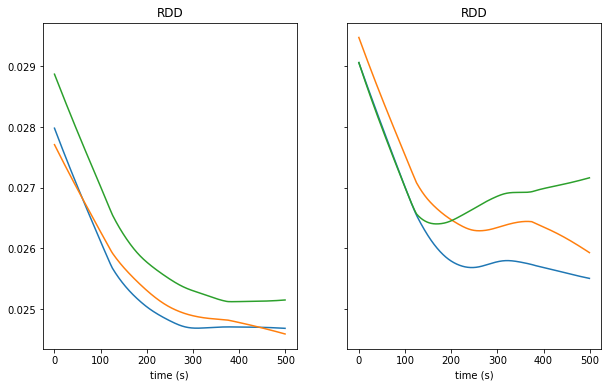

In [958]:
#Make some plots of progress
fig, axes = plt.subplots(1,2, sharey = True)
tt=10
time = DeltaT*dt*np.arange(costs_pert.shape[-1]-tt)

#Smooth with loess
#RDD
for idx in range(len(cvals)):
    pp = np.mean(costs_pert[idx,0,:,tt:], 0)
    filtered = lowess(pp, time, is_sorted=True, frac=0.5, it=0)
    axes[0].plot(filtered[:,0], (filtered[:,1]))
    #axes[0].plot(filtered[:,0], np.log(filtered[:,1]))

axes[0].set_xlabel('time (s)')
axes[0].set_title('RDD')
#axes[0].set_ylim([0, 0.02])

#OD
for idx in range(len(cvals)):
    pp = np.mean(costs_pert[idx,1,:,tt:], 0)
    filtered = lowess(pp, time, is_sorted=True, frac=0.5, it=0)
    axes[1].plot(filtered[:,0], (filtered[:,1]))
    #axes[1].plot(filtered[:,0], np.log(filtered[:,1]))

axes[1].set_xlabel('time (s)')
axes[1].set_title('OD')
#axes[1].set_ylim([0, 0.02])

plt.savefig('./fig_6.eps')

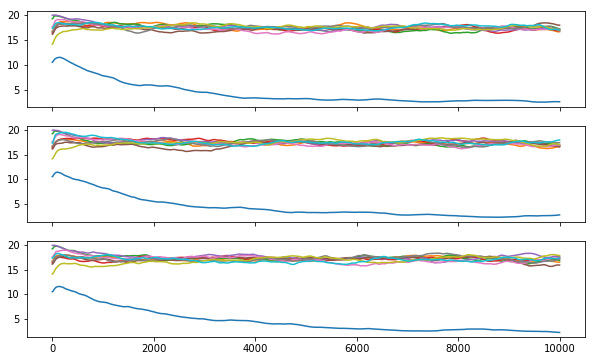

In [897]:
#Check what the weights are doing

#W_rdd_trace_pert[cidx,pidx,Nsim,time,weightidx]
#Example
fig, axes = plt.subplots(3,1, sharex = True)
axes[0].plot(np.mean(W_rdd_trace_pert[0,0,:,:,:], 0));
axes[1].plot(np.mean(W_rdd_trace_pert[1,0,:,:,:], 0));
axes[2].plot(np.mean(W_rdd_trace_pert[2,0,:,:,:], 0));

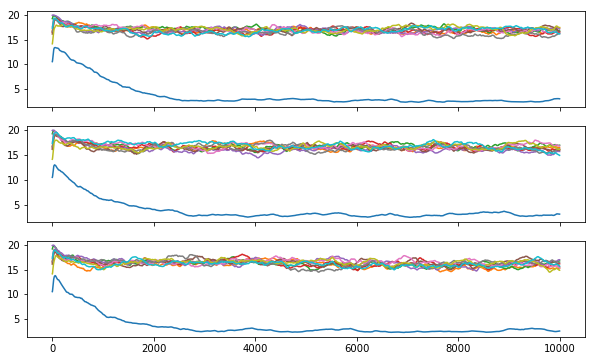

In [898]:
fig, axes = plt.subplots(3,1, sharex = True)
axes[0].plot(np.mean(W_rdd_trace_pert[0,1,:,:,:], 0));
axes[1].plot(np.mean(W_rdd_trace_pert[1,1,:,:,:], 0));
axes[2].plot(np.mean(W_rdd_trace_pert[2,1,:,:,:], 0));

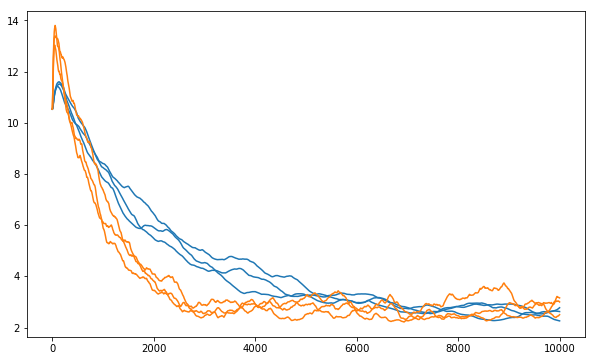

In [899]:
plt.plot(np.mean(W_rdd_trace_pert[0,0,:,:,0], 0), 'C0')
plt.plot(np.mean(W_rdd_trace_pert[1,0,:,:,0], 0), 'C0')
plt.plot(np.mean(W_rdd_trace_pert[2,0,:,:,0], 0), 'C0')

plt.plot(np.mean(W_rdd_trace_pert[0,1,:,:,0], 0), 'C1')
plt.plot(np.mean(W_rdd_trace_pert[1,1,:,:,0], 0), 'C1')
plt.plot(np.mean(W_rdd_trace_pert[2,1,:,:,0], 0), 'C1')

## Dual control task

In [10]:
U_p = np.zeros((1, n))
#Target neuron is first neuron
U_p[0,0] = 1
#target_p = np.ones((1,1))*0.1
#target_p = np.ones((1,1))*0

targetpval = 0
target_p = target.copy()
target_p[0] = targetpval

gamma = 1

W_rdd_orig = W_rdd.copy()

In [11]:
np.dot(U_p, np.ones((1,n)).T) - 1
target_p

array([ 0.  ,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02])

In [12]:
cvals = [0.1, 0.3, 0.5, 0.7, 0.9]
pvals = [0.2, 1]
epsilon_vals = [1e4, 5e4]

Nsims = 40

nCvals = len(cvals)
nPvals = len(pvals)

W_rdd_trace_pert = np.zeros((nCvals, nPvals, Nsims, T, n))
V_trace_pert = np.zeros((nCvals, nPvals, Nsims, T, n))
costs_pert = np.zeros((nCvals, nPvals, Nsims, T))

In [13]:
#Simulate with RDD learning rule for original cost function, same simulation can be used for all c values. 
#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go

for cidx, c in enumerate(cvals):
    print 'Running for c = %f'%c
    for pidx, p in enumerate(pvals):
        print 'Running for p = %f'%p
        epsilon = epsilon_vals[pidx] 

        #Update lif object's c value
        params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c, n = n)

        for idx in range(Nsims):
            #Create the filtered output vectors now, fill them as we go
            #s_raw = np.zeros((n,int(T/dt)))
            s_raw = np.zeros((n, T*DeltaT))

            lif_rdd = LIF(params_lif, t = DeltaT*dt, t_total = tsim)
            lif_rdd.W = W_rdd_orig.copy()
            lif_rdd.x = x_input

            count = np.zeros(n)
            sys.stdout.write('.')
            sys.stdout.flush()

            lif_rdd.count = 0
            bt = [False]*n

            V = np.zeros((n, q))
            #Then just repeat the learning rule as before
            dV = np.zeros(V.shape)

            for j in range(T):
                #Simulate LIF for RDD
                #print("t = %d"%j)
                (v_raw, h_raw, _, _, u_raw) = lif_rdd.simulate(DeltaT)

                t_offset = j*DeltaT
                for k in range(n):
                    convolve_online(s_raw[k,:], h_raw[k,:], exp_filter, t_offset)
                nB = h_raw.shape[1]/DeltaT 
                um = u_raw.reshape((n, nB, DeltaT))
                u = np.max(um, 2)

                cost = C_perturb_DC(s_raw[:,t_offset+DeltaT-1])
                #print cost         
                for k in range(n):
                    if (u[k,0] > mu - p) & (u[k,0] < mu):
                        if bt[k] == False:
                            if linearcorrection == True:
                                ahat = np.array([1, 0, -(u[k,0]-mu)])
                            else:
                                ahat = np.array([1, 0, 0])
                            dV[k,:] += (np.dot(V[k,:], ahat)+cost)*ahat                    
                            bt[k] = True
                    elif (u[k,0] < mu + p) & (u[k,0] >= mu):
                        #Only do the update when firing...
                        if bt[k] == True:
                            if linearcorrection == True:
                                ahat = np.array([1, (u[k,0]-mu), 0])
                            else:
                                ahat = np.array([1, 0, 0])
                            dV[k,:] += (np.dot(V[k,:], ahat)-cost)*ahat                                        
                            count[k] += 1
                            if decaystepsize == True:
                                V[k,:] = V[k,:] - eta*dV[k,:]/(count[k]+1)
                            else:
                                V[k,:] = V[k,:] - eta*dV[k,:]
                            dV[k,:] = np.zeros((1,q))
                            bt[k] = False
                
                #At end of episode, update weights according to V for RDD
                if j*DeltaT*dt > t_no_w:
                    lif_rdd.W -= epsilon*np.multiply(V[:,0], mu_mean(lif_rdd.W, wmin, wmax, Nmu))#/(j+100)
                    lif_rdd.W = np.maximum(np.minimum(lif_rdd.W, wmax), wmin)
                W_rdd_trace_pert[cidx, pidx, idx,j,:] = lif_rdd.W
                V_trace_pert[cidx, pidx, idx,j,:] = V[:,0]
                costs_pert[cidx, pidx, idx,j] = cost

Running for c = 0.100000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.300000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.500000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.700000
Running for p = 0.200000
....................Running for p = 1.000000
....................Running for c = 0.900000
Running for p = 0.200000
....................Running for p = 1.000000
....................

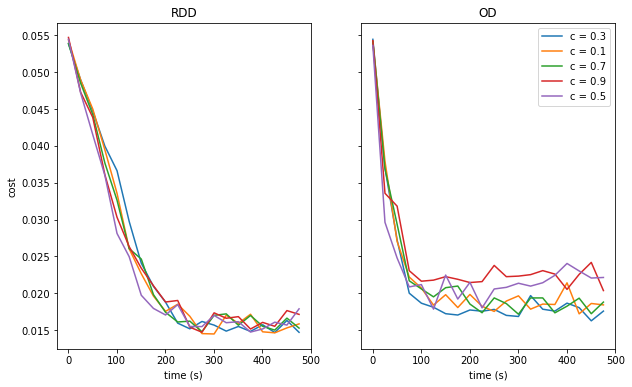

In [16]:
#Make some plots of progress
fig, axes = plt.subplots(1,2, sharey = True)

#RDD
tt=10
step = 500
ii = np.arange(tt,costs_pert.shape[-1],step).T
axes[0].plot(DeltaT*dt*ii, np.mean(costs_pert[:,0,:,ii],2))
axes[0].set_xlabel('time (s)')
axes[0].set_title('RDD')
axes[0].set_ylabel('cost')
#OD
axes[1].set_title('OD')
axes[1].plot(DeltaT*dt*ii, np.mean(costs_pert[:,1,:,ii],2))
axes[1].set_xlabel('time (s)')
axes[1].legend(['c = 0.1', 'c = 0.3', 'c = 0.5', 'c = 0.7','c = 0.9'])

In [984]:
ii.shape

(10000,)

/home/lansdell/.local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0.01, 0.04)

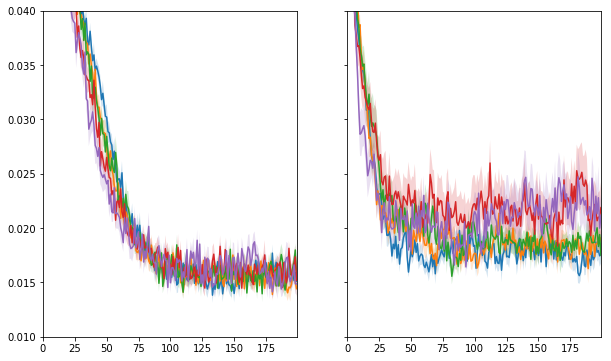

In [17]:
fig, axes = plt.subplots(1,2, sharey = True)
tt=10
step = 50
ii = np.arange(0,costs_pert.shape[-1],step)
times = DeltaT*dt*ii

for idx in range(len(cvals)):
    sns.tsplot(data = costs_pert[idx,0,:,ii].T, ax = axes[0], color='C%d'%idx)
    sns.tsplot(data = costs_pert[idx,1,:,ii].T, ax = axes[1], color='C%d'%idx)

axes[0].set_ylim([0.01, 0.04])
axes[1].set_ylim([0.01, 0.04])

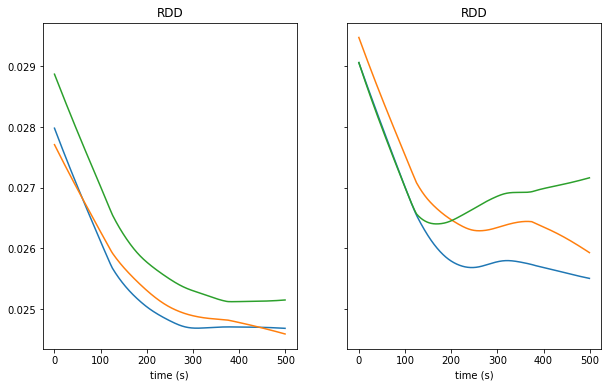

In [958]:
#Make some plots of progress
fig, axes = plt.subplots(1,2, sharey = True)
tt=10
time = DeltaT*dt*np.arange(costs_pert.shape[-1]-tt)

#Smooth with loess
#RDD
for idx in range(len(cvals)):
    pp = np.mean(costs_pert[idx,0,:,tt:], 0)
    filtered = lowess(pp, time, is_sorted=True, frac=0.5, it=0)
    axes[0].plot(filtered[:,0], (filtered[:,1]))
    #axes[0].plot(filtered[:,0], np.log(filtered[:,1]))

axes[0].set_xlabel('time (s)')
axes[0].set_title('RDD')
#axes[0].set_ylim([0, 0.02])

#OD
for idx in range(len(cvals)):
    pp = np.mean(costs_pert[idx,1,:,tt:], 0)
    filtered = lowess(pp, time, is_sorted=True, frac=0.5, it=0)
    axes[1].plot(filtered[:,0], (filtered[:,1]))
    #axes[1].plot(filtered[:,0], np.log(filtered[:,1]))

axes[1].set_xlabel('time (s)')
axes[1].set_title('OD')
#axes[1].set_ylim([0, 0.02])

plt.savefig('./fig_6.eps')

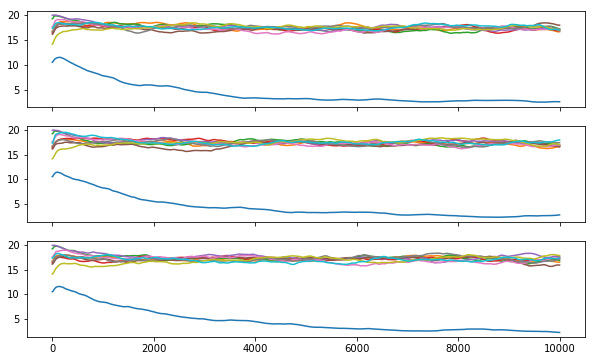

In [897]:
#Check what the weights are doing

#W_rdd_trace_pert[cidx,pidx,Nsim,time,weightidx]
#Example
fig, axes = plt.subplots(3,1, sharex = True)
axes[0].plot(np.mean(W_rdd_trace_pert[0,0,:,:,:], 0));
axes[1].plot(np.mean(W_rdd_trace_pert[1,0,:,:,:], 0));
axes[2].plot(np.mean(W_rdd_trace_pert[2,0,:,:,:], 0));

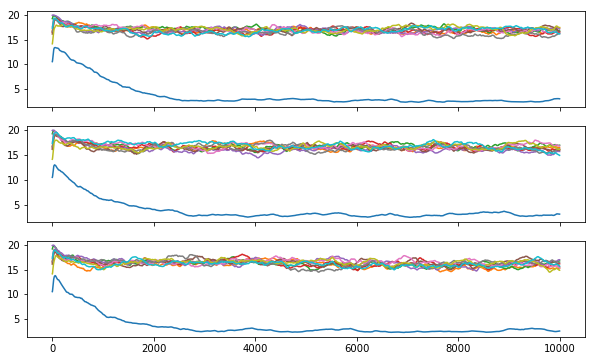

In [898]:
fig, axes = plt.subplots(3,1, sharex = True)
axes[0].plot(np.mean(W_rdd_trace_pert[0,1,:,:,:], 0));
axes[1].plot(np.mean(W_rdd_trace_pert[1,1,:,:,:], 0));
axes[2].plot(np.mean(W_rdd_trace_pert[2,1,:,:,:], 0));

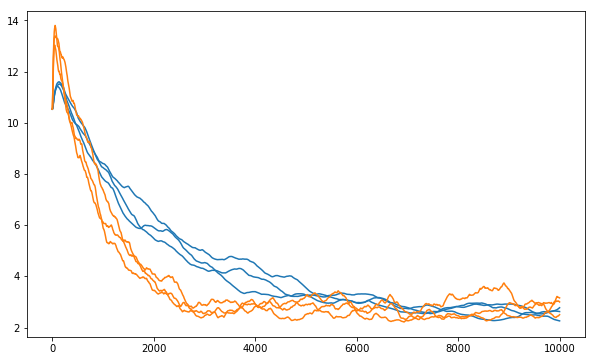

In [899]:
plt.plot(np.mean(W_rdd_trace_pert[0,0,:,:,0], 0), 'C0')
plt.plot(np.mean(W_rdd_trace_pert[1,0,:,:,0], 0), 'C0')
plt.plot(np.mean(W_rdd_trace_pert[2,0,:,:,0], 0), 'C0')

plt.plot(np.mean(W_rdd_trace_pert[0,1,:,:,0], 0), 'C1')
plt.plot(np.mean(W_rdd_trace_pert[1,1,:,:,0], 0), 'C1')
plt.plot(np.mean(W_rdd_trace_pert[2,1,:,:,0], 0), 'C1')